In [32]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from typing import List
from src.helper_methods import *
from src.pipe_store import *
warnings.filterwarnings('ignore')


# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [33]:
print(plt.style.available)
plt.style.use('fivethirtyeight') 

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


# Heper functions

In [37]:
def get_mAbs(path:str, isotype:List[str]=None):
    """ 
    Method to get the monoclonal antibodies from the HLA Epitope Registry 
    
    Parameters:
    -----------
        path: str
            Path to the epitope database

        isotype: List[str], default None
            In default mode, all the monoclonal antibodies are included irrespective of their isotype.
    """

    epitope_df = pd.read_pickle(path)
    ind_mab = epitope_df.mAb == 'Yes'
    if isotype:
        ind_isotype = epitope_df['isotype'].apply(lambda x: x in isotype)
    else:
        ind_isotype = True
    return  set(epitope_df[ind_mab & ind_isotype].Epitope.values.tolist())


# Load Dataset

In [38]:
path_cohort = '~/UMCUtrecht/KaplanMeier/DESAsurvival.pickle'
path_antibody = '~/UMCUtrecht/20211104_mismatch_ep_db.pickle'
df_abs = pd.read_pickle(path_antibody)
df_cohort = pd.read_pickle(path_cohort)
df = df_abs.merge(df_cohort, on='TransplantID')
print(df.columns)
cols = [
    'TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA', 'RecipientAge_NOTR', 
    'DonorAge_NOTR', 'TypeOfDonor_NOTR', 'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb',
    'CIPHour_DBD', 'CIPHour_DCD' , 'LivingDonorNum', 
]
df = df[cols]
df.columns

Index(['TransplantID', 'Epitope_Mismatch', 'DESA_Status', 'EpvsHLA_Donor',
       '#DESA', 'DESA', 'RecipientAge_NOTR', 'RecipientSex_NOTR',
       'DonorAge_NOTR', 'DonorSex_NOTR', 'Retransplant', 'TxYear', 'Center',
       'TypeOfDonor_NOTR', 'LivingDonorNum', 'GraftFunction_NOTR',
       'ColdIschaemicPeriod_NOTR', 'CIPHour', 'CIPHour_DBD', 'CIPHour_DCD',
       'CurrentPRA_NOTR', 'HighPRA_NOTR', 'IL2rMoAb', 'GraftSurvival10y',
       'GraftSurvival10Y_R', 'GraftSurvival1y', 'GraftSurvivalY1_R',
       'FailureCode10y', 'FailureCode10Y_R', 'FailureCode1Y_R',
       'FailureCode1y', 'RejectionCodeY10_R', 'PatientSurvival10Y',
       'PatientDeathCode10Y', 'GraftSurvival3m', 'FailureCode3m'],
      dtype='object')


Index(['TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA',
       'RecipientAge_NOTR', 'DonorAge_NOTR', 'TypeOfDonor_NOTR',
       'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb', 'CIPHour_DBD',
       'CIPHour_DCD', 'LivingDonorNum'],
      dtype='object')

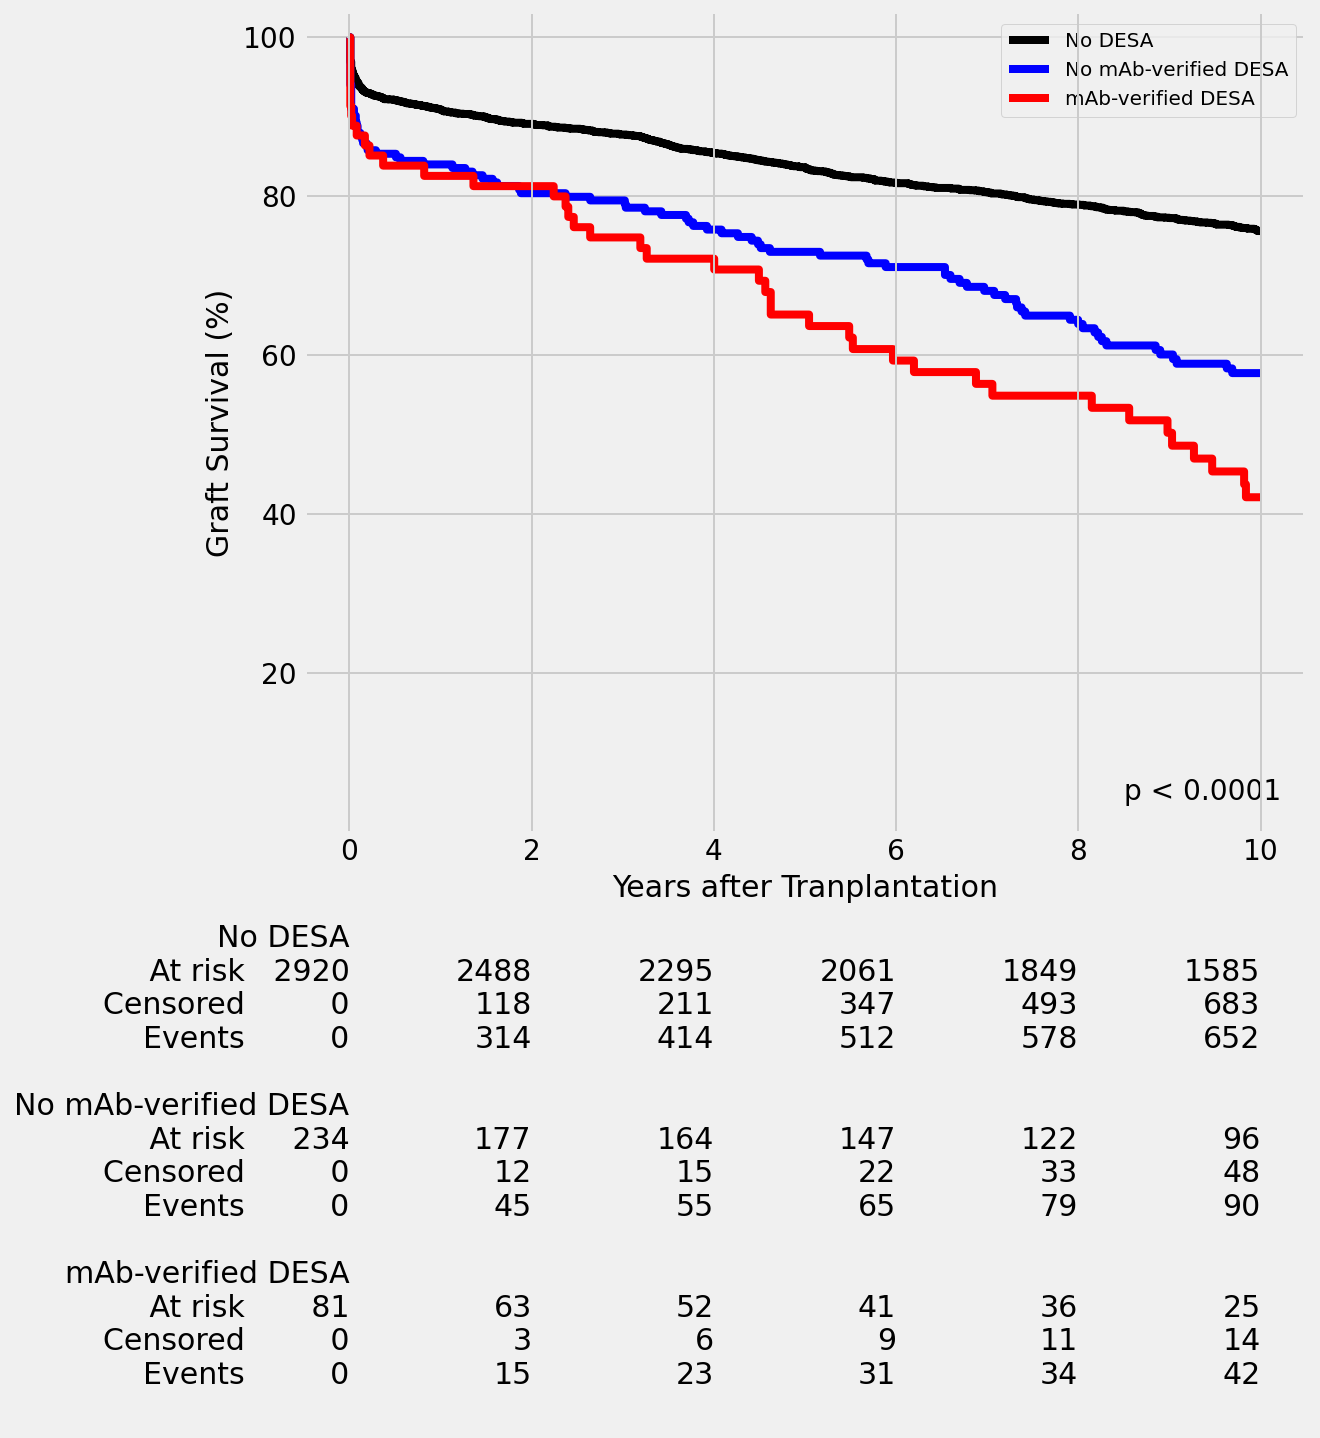

In [56]:
from src.constants import *

confounders = [
    'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
    'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
    'CIPHour_DBD', 'CIPHour_DCD', 
]

path = '/Users/Danial/UMCUtrecht/EpitopevsHLA.pickle' 
mAbs = get_mAbs(
    path,
    isotype=['IgG']
)
df = df.assign(
                No_DESA = df['DESA'].apply(lambda x: 0 if x else 1),
                mAb_presence = df['DESA'].apply(lambda x: 1 if x.intersection(mabs) else 0),
                mAb_absence =  df['DESA'].apply(lambda x: 1 if not x.intersection(mabs) else 0),
            )
df = df.assign(
        Groups = df[['No_DESA', 'mAb_presence', 'mAb_absence']].values.argmax(1) + 1
    )

treatments = ['No_DESA', 'mAb_absence', 'mAb_presence']
df_weight = find_ipw(df, confounders, treatments, verbose=False)
labels = ['No DESA', 'No mAb-verified DESA', 'mAb-verified DESA']
kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=mAbs, labels=labels, adjust=False)
plot_kaplan_meier_curve(kmfs, p_value, grid=True)